# Support Vector Machines nos dados covtype de LIBSVM

Iremos treinar os dados para classificação binária usando os dados `covtype` da biblioteca [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Veja também [Kaggle-LIBSVM](https://www.kaggle.com/code/tanmayunhale/libsvm-liblinear).

Desta vez, iremos usar o algoritmo SVM:

$$
\min_{w\in {\mathbb R}^{d\times1}} f_n(w)=\frac{1}{n}\sum_{i=1}^n \max\{0,1-y_i(x_i^\top w)\} + \frac{\gamma}{2}\|w\|^2,
$$

onde $x_i\in {\mathbb R}^{d\times1}$, $y_i\in \{-1, 1\}$. Uma diferença em relação à regressão logística é que a função custo não é diferenciável. Um subgradiente num ponto $w$ é dado por

$$
g_n(w) = -\frac{1}{n}\sum_{i=1}^n\mathbb{1}_{\{y_i(x_i^\top w)<1\}}y_ix_i + \gamma w.
$$

Portanto, poderíamos usar o método subgradiente. Neste projeto, entretanto, iremos considerar o caso em que $n$ é muito grande de modo que avaliar $f(w)$ ou $g(w)$ é muito custoso. Note que $f(w)$ é a média empírica de 

$$
F_i(w) := \max\{0,1-y_i(x_i^\top w)\} + \frac{\gamma}{2}\|w\|^2.
$$

Alternativamente iremos usar em cada iteração um único ponto da amostra e aplicar o método subgradiente estocástico com o subgradiente:

$$
G_i(w) := -\mathbb{1}_{\{y_i(x_i^\top w)<1\}}y_ix_i + \gamma w.
$$

NOTA: neste projeto os labels devem estar em $\{-1,1\}$!

In [1]:
# Importação de módulos necesserários:

import matplotlib
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file
from sklearn.utils.extmath import safe_sparse_dot

In [4]:
# Lendo os dados do arquivo covtype e guardando na matriz de dados X e vetor de labels y:

data = load_svmlight_file('covtype')
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Devemos garantir que os labels estão em {-1, 1}
    y[y==1.] = -1
    y[y==2.] = 1
    
n, d = X.shape # tamanho da amostra, número de features    

# Exercício 1: Funções auxiliares

1. Construa uma função `f(w, l2, m)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o valor funcional $f_{m}(w)$ para algum $m\in[n]$.
2. Construa uma função `G(w, i, l2)` toma o iterado `w`, os dados $(x_i,y_i)$ e a penalização $\gamma$ (=`l2`) e retorna o subgradiente $G_i(w)$.
3. Construa uma função `g(w, l2, m)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o subgradiente  $g_{m}(w)$ para algum $m\in[n]$ --- isto é, a média de $m$ subgradientes.
4. Construa uma função `gB(w, l2, B)` que toma o iterado `w` e a penalização $\gamma$ (=`l2`) e retorna o gradiente  $g_{B}(w)=\frac{1}{B}\sum_{i\in I_B}G_i(w)$ para algum $B\in[n]$ onde $I_B\subset[n]$ é escolhido aleatoriamente/uniformente. 

In [5]:
# Função f(w, l2, m): Calcula o valor funcional f_m(w) para algum m∈[n]
def f(w, l2, m):
    """Calcula o valor funcional f_m(w) para m exemplos."""
    loss = 0
    for i in range(m):
        margin = 1 - y[i] * np.dot(X[i], w)
        hinge_loss = max(0, margin)
        loss += hinge_loss
    loss = loss / m  # Média do hinge loss
    regularization = (l2 / 2) * np.dot(w, w)  # Termo de regularização
    return loss + regularization

# Função G(w, i, l2): Calcula o subgradiente G_i(w) para um exemplo i
def G(w, i, l2):
    """Calcula o subgradiente G_i(w) para o exemplo i."""
    x_i = X[i]
    y_i = y[i]
    if y_i * np.dot(x_i, w) < 1:
        subgradient = -y_i * x_i + l2 * w
    else:
        subgradient = l2 * w
    return subgradient

# Função g(w, l2, m): Calcula o subgradiente médio para m exemplos
def g(w, l2, m):
    """Calcula o subgradiente médio para m exemplos."""
    subgradient = np.zeros_like(w)
    for i in range(m):
        subgradient += G(w, i, l2)
    return subgradient / m

# Função gB(w, l2, B): Calcula o gradiente médio para um minibatch de tamanho B
def gB(w, l2, B):
    """Calcula o gradiente médio para um minibatch de tamanho B."""
    indices = np.random.choice(n, B, replace=False)  # Escolha aleatória de índices
    subgradient = np.zeros_like(w)
    for i in indices:
        subgradient += G(w, i, l2)
    return subgradient / B

# Inicialização

Fixaremos:

In [6]:
m = 30000
l2 = 1e+2
w0 = np.zeros(d)        # ponto inicial
it_max = 80000          # número de iterações
B = 100

# Exercício 2: Método subgradiente estocástico 1 

Iremos implementar o algoritmo [Pegasos](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cs.huji.ac.il/~shais/papers/ShalevSiSrCo10.pdf)

Construa uma função `sgd(f, G, w0, lr, l2, m, it_max)` que toma como entrada as funções `g()` `G()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$, passo `lr`,  `m` e implementa o método subgradiente estocástico em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k G_k(w_k), 
$$

com passo $\alpha_k=\frac{lr}{\gamma k}$. **Na $k$-ézima iteração, use o ponto amostral $(x_k,y_k)$, na ordem do data set `X,y`**. Esta função deve retornar a sequência 

$$
k\mapsto f_{m}(w_k)=\frac{1}{m}\sum_{i=1}^{m} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$  

A função também deve retornar o último iterado.

In [7]:
def sgd(f, G, w0, lr, l2, m, it_max):
    w = w0
    valores_f = []
    for k in range(1, it_max + 1):
        i_k = np.random.randint(0, len(X))  
        grad = G(w, i_k, l2)  
        alpha_k = lr / k  
        w = w - alpha_k * grad
        if k % 1000 == 0:
            valor_f = f(w, l2, m)
            valores_f.append(valor_f)
            print(f"Iteração {k}/{it_max}: f_m(w) = {valor_f:.4f}")
    return valores_f, w

In [8]:
# gradient descent
f1 = sgd(f, G, w0, 1e-1, l2, m, it_max)

Iteração 1000/80000: f_m(w) = 719.1410
Iteração 2000/80000: f_m(w) = 180.9825
Iteração 3000/80000: f_m(w) = 180.5645
Iteração 4000/80000: f_m(w) = 133.0035
Iteração 5000/80000: f_m(w) = 213.9118
Iteração 6000/80000: f_m(w) = 107.2928
Iteração 7000/80000: f_m(w) = 180.3923
Iteração 8000/80000: f_m(w) = 143.2728
Iteração 9000/80000: f_m(w) = 59.6635
Iteração 10000/80000: f_m(w) = 84.1726
Iteração 11000/80000: f_m(w) = 18.8172
Iteração 12000/80000: f_m(w) = 92.4162
Iteração 13000/80000: f_m(w) = 20.1387
Iteração 14000/80000: f_m(w) = 26.2437
Iteração 15000/80000: f_m(w) = 35.0601
Iteração 16000/80000: f_m(w) = 35.3179
Iteração 17000/80000: f_m(w) = 11.3141
Iteração 18000/80000: f_m(w) = 32.2053
Iteração 19000/80000: f_m(w) = 17.8139
Iteração 20000/80000: f_m(w) = 21.1677
Iteração 21000/80000: f_m(w) = 8.3298
Iteração 22000/80000: f_m(w) = 22.9954
Iteração 23000/80000: f_m(w) = 36.6842
Iteração 24000/80000: f_m(w) = 25.2283
Iteração 25000/80000: f_m(w) = 27.4515
Iteração 26000/80000: f_m(w

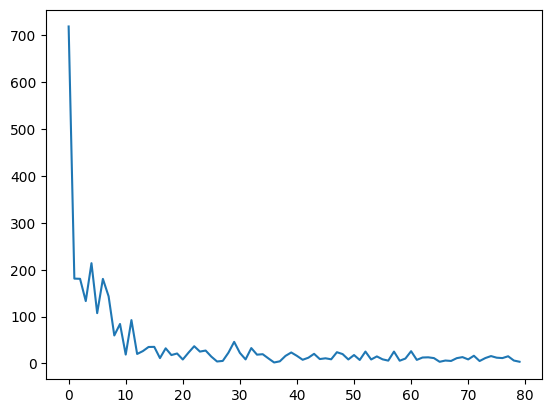

In [9]:
plt.plot(f1[0])

# Exercício 3: Método subgradiente estocástico 2

Construa uma função `sgd2(f, G, w0, lr, l2, m, it_max)` que toma como entrada as funções `g` `G()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$, `m` e implementa o método subgradiente estocástico em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k G_{i_k}(w_k),
$$

com passo $\alpha_k=\frac{lr}{\gamma k}$, onde **na $k$-ézima iteração, $i_k\in[n]$ é escolhido uniformemente ao acaso, usand o ponto amostral $(x_{i_k},y_{i_k})$**. Esta função deve retornar a sequência 

$$
k\mapsto f_{m}(w_k)=\frac{1}{m}\sum_{i=1}^{m} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$ 

A função também deve retornar o último iterado.

In [10]:
def sgd2(f, G, w0, lr, l2, m, it_max):
    """
    Implementa o método subgradiente estocástico.
    
    Parâmetros:
    - f: função objetivo que calcula f_m(w)
    - G: função para calcular o subgradiente G_i(w)
    - w0: vetor inicial
    - lr: taxa de aprendizado inicial
    - l2: penalização (regularização)
    - m: número de amostras para avaliar f_m(w)
    - it_max: número máximo de iterações
    
    Retorna:
    - valores_f: sequência de valores f_m(w_k) ao longo das iterações
    - w: o último iterado w
    """
    # Inicializar o vetor w e lista para armazenar valores de f_m(w_k)
    w = w0
    valores_f = []
    
    for k in range(1, it_max + 1):
        # Escolher um índice aleatório uniformemente em [0, n-1]
        i_k = np.random.randint(0, n)
        
        # Calcular o subgradiente estocástico
        grad = G(w, i_k, l2)
        
        # Atualizar w usando o passo de aprendizado
        alpha_k = lr / (l2 * k)  # Definição do passo
        w = w - alpha_k * grad
        
        # Avaliar a função f_m(w_k) e armazenar
        if k % 1000 == 0:  # Avaliar a cada 1000 iterações para eficiência
            valor_f = f(w, l2, m)
            valores_f.append(valor_f)
            print(f"Iteração {k}/{it_max}: f_m(w) = {valor_f:.4f}")
    
    return valores_f, w

In [11]:
# gradient descent
f2 = sgd2(f, G, w0, 1e-1, l2, m, it_max)

Iteração 1000/80000: f_m(w) = 14.5464
Iteração 2000/80000: f_m(w) = 10.1753
Iteração 3000/80000: f_m(w) = 6.3554
Iteração 4000/80000: f_m(w) = 6.4064
Iteração 5000/80000: f_m(w) = 4.5874
Iteração 6000/80000: f_m(w) = 4.1284
Iteração 7000/80000: f_m(w) = 3.1695
Iteração 8000/80000: f_m(w) = 3.9926
Iteração 9000/80000: f_m(w) = 2.6620
Iteração 10000/80000: f_m(w) = 2.9840
Iteração 11000/80000: f_m(w) = 2.3984
Iteração 12000/80000: f_m(w) = 3.2637
Iteração 13000/80000: f_m(w) = 2.3711
Iteração 14000/80000: f_m(w) = 1.7148
Iteração 15000/80000: f_m(w) = 2.1454
Iteração 16000/80000: f_m(w) = 2.2126
Iteração 17000/80000: f_m(w) = 1.7523
Iteração 18000/80000: f_m(w) = 1.4148
Iteração 19000/80000: f_m(w) = 1.7976
Iteração 20000/80000: f_m(w) = 1.6525
Iteração 21000/80000: f_m(w) = 1.3952
Iteração 22000/80000: f_m(w) = 1.1743
Iteração 23000/80000: f_m(w) = 1.3776
Iteração 24000/80000: f_m(w) = 1.6641
Iteração 25000/80000: f_m(w) = 1.3558
Iteração 26000/80000: f_m(w) = 1.2046
Iteração 27000/8000

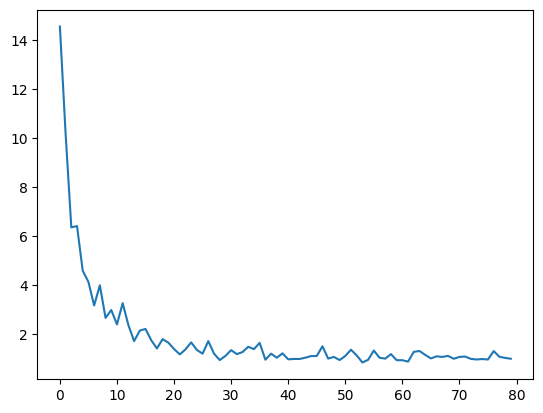

In [12]:
plt.plot(f2[0])

# Exercício 4: Método subgradiente estocástico 3

Construa agora função `sgd3(f, gB, w0, lr, l2, m, B, it_max)` que toma como entrada as funções `f` `gB()`, o ponto inicial `w0`, a regularização `l2` $(=\gamma)$ e implementa o método subgradiente estocástico com mini-batch size `B` em `it_max` iterações iniciando de `w0`:

$$
w_{k+1} = w_k - \alpha_k \cdot\frac{1}{B}\sum_{i\in B_k}G_{i}(w_k),
$$

onde **na $k$-ézima iteração, $B_k\subset\in[n]$ é escolhido uniformemente ao acaso, usando o mini-batch $\{(x_{i},y_{i})\}_{i\in B_k}$**. Esta função deve retornar a sequência 

$$
k\mapsto f_{\text{it_max}}(w_k)=\frac{1}{\text{it_max}}\sum_{i=1}^{\text{it_max}} \max\{0,1-y_i(x_i^\top w_k)\} + \frac{\gamma}{2}\|w_k\|^2.
$$ 

A função também deve retornar o último iterado. Implemente com passo $\alpha_k=\frac{lr}{\gamma k}$.  

In [13]:
def sgd3(f, gB, w0, lr, l2, m, B, it_max):
    """
    Implementa o método subgradiente estocástico com mini-batches.
    
    Parâmetros:
    - f: função objetivo que calcula f_m(w)
    - gB: função que calcula o gradiente médio para um mini-batch
    - w0: vetor inicial
    - lr: taxa de aprendizado inicial
    - l2: penalização (regularização)
    - m: número de amostras para avaliar f_m(w)
    - B: tamanho do mini-batch
    - it_max: número máximo de iterações
    
    Retorna:
    - valores_f: sequência de valores f_m(w_k) ao longo das iterações
    - w: o último iterado w
    """
    # Inicializar o vetor w e lista para armazenar valores de f_m(w_k)
    w = w0
    valores_f = []
    
    for k in range(1, it_max + 1):
        # Calcular o gradiente médio no mini-batch
        grad = gB(w, l2, B)
        
        # Atualizar w usando o passo de aprendizado
        alpha_k = lr / (l2 * k)  # Definição do passo
        w = w - alpha_k * grad
        
        # Avaliar a função f_m(w_k) e armazenar
        if k % 1000 == 0:  # Avaliar a cada 1000 iterações para eficiência
            valor_f = f(w, l2, m)
            valores_f.append(valor_f)
            print(f"Iteração {k}/{it_max}: f_m(w) = {valor_f:.4f}")
    
    return valores_f, w

In [14]:
f3 = sgd3(f, gB, w0, 1e-1, l2, m, B, it_max)

Iteração 1000/80000: f_m(w) = 1.3074
Iteração 2000/80000: f_m(w) = 0.8325
Iteração 3000/80000: f_m(w) = 0.8289
Iteração 4000/80000: f_m(w) = 0.8029
Iteração 5000/80000: f_m(w) = 1.0604
Iteração 6000/80000: f_m(w) = 0.8641
Iteração 7000/80000: f_m(w) = 0.8109
Iteração 8000/80000: f_m(w) = 0.8326
Iteração 9000/80000: f_m(w) = 0.8913
Iteração 10000/80000: f_m(w) = 0.8490
Iteração 11000/80000: f_m(w) = 0.7989
Iteração 12000/80000: f_m(w) = 0.8330
Iteração 13000/80000: f_m(w) = 0.8189
Iteração 14000/80000: f_m(w) = 0.8686
Iteração 15000/80000: f_m(w) = 0.8602
Iteração 16000/80000: f_m(w) = 0.8440
Iteração 17000/80000: f_m(w) = 0.8418
Iteração 18000/80000: f_m(w) = 0.8274
Iteração 19000/80000: f_m(w) = 0.8388
Iteração 20000/80000: f_m(w) = 0.8585
Iteração 21000/80000: f_m(w) = 0.8651
Iteração 22000/80000: f_m(w) = 0.8266
Iteração 23000/80000: f_m(w) = 0.8432
Iteração 24000/80000: f_m(w) = 0.8288
Iteração 25000/80000: f_m(w) = 0.8323
Iteração 26000/80000: f_m(w) = 0.8600
Iteração 27000/80000:

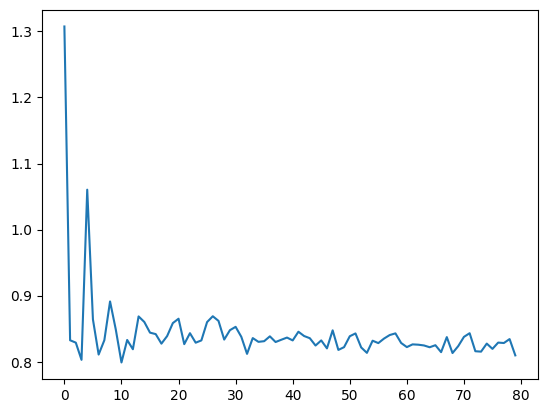

In [15]:
plt.plot(f3[0])

# Exercício 5: 

Implemente num mesmo gráfico os erros $f_{\text{it_max}}(w_k)$ de cada método em função no número de iterações.

Iteração 1000/8000: f_m(w) = 95.3792
Iteração 2000/8000: f_m(w) = 30.3821
Iteração 3000/8000: f_m(w) = 5.1051
Iteração 4000/8000: f_m(w) = 25.0343
Iteração 5000/8000: f_m(w) = 6.1553
Iteração 6000/8000: f_m(w) = 20.5463
Iteração 7000/8000: f_m(w) = 11.5005
Iteração 8000/8000: f_m(w) = 9.9258
Iteração 1000/8000: f_m(w) = 2.5961
Iteração 2000/8000: f_m(w) = 1.7038
Iteração 3000/8000: f_m(w) = 1.6478
Iteração 4000/8000: f_m(w) = 1.0799
Iteração 5000/8000: f_m(w) = 1.0708
Iteração 6000/8000: f_m(w) = 0.6747
Iteração 7000/8000: f_m(w) = 0.9756
Iteração 8000/8000: f_m(w) = 0.5926
Iteração 1000/8000: f_m(w) = 0.6379
Iteração 2000/8000: f_m(w) = 0.5733
Iteração 3000/8000: f_m(w) = 0.5937
Iteração 4000/8000: f_m(w) = 0.5783
Iteração 5000/8000: f_m(w) = 0.6606
Iteração 6000/8000: f_m(w) = 0.6193
Iteração 7000/8000: f_m(w) = 0.6047
Iteração 8000/8000: f_m(w) = 0.5862


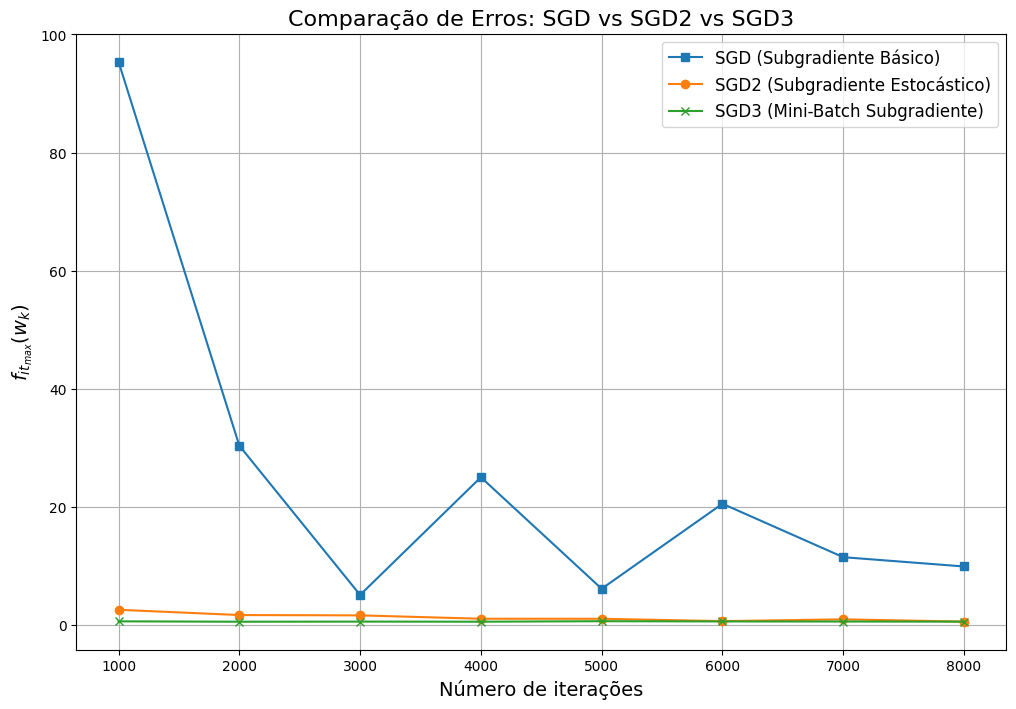

In [19]:
lr = 0.01
it_max = 8000
# Executar os três métodos
valores_sgd, _ = sgd(f, G, w0, lr, l2, m, it_max)
valores_sgd2, _ = sgd2(f, G, w0, lr, l2, m, it_max)
valores_sgd3, _ = sgd3(f, gB, w0, lr, l2, m, 32, it_max)

# Criar os vetores de iterações correspondentes
iteracoes = list(range(1000, it_max + 1, 1000))

# Plotar os erros de cada método
plt.figure(figsize=(12, 8))
plt.plot(iteracoes, valores_sgd, label='SGD (Subgradiente Básico)', marker='s')
plt.plot(iteracoes, valores_sgd2, label='SGD2 (Subgradiente Estocástico)', marker='o')
plt.plot(iteracoes, valores_sgd3, label='SGD3 (Mini-Batch Subgradiente)', marker='x')

# Adicionar título e legendas
plt.title('Comparação de Erros: SGD vs SGD2 vs SGD3', fontsize=16)
plt.xlabel('Número de iterações', fontsize=14)
plt.ylabel('$f_{it_{max}}(w_k)$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Exibir o gráfico
plt.show()

# Exercício 6:

Nos exercícios anteriores, usamos os $m$ primeiros pontos de dados `y[:m], X[:m]` para plotar a sequência $k\mapsto f_m(w_k)$. Isto não é ideal já que usamos também todo ou parte de `y[:m], X[:m]` para construir a sequência de iterados $k\mapsto w_k$. Refaça os 3 exercícios anteriores mas antes dividindo o data set `y, X` em duas partes 
`y[n-m:], X[n-m:]` e `y[:n-m], X[:n-m]`. Use o dataset `y[:n-m], X[:n-m]` de tamanho `n-m` para construir a sequência de iterados $k\mapsto w_k$ e `y[n-m:], X[n-m:]` de tamanho `m` para computar $f_m(w)$ para cada iterado $w$. Plote os 3 gráficos correspondentes e depois o gráfico com os 6 métodos diferentes. Você nota alguma diferença?

In [28]:
# Função f_m(w): Calcula o valor funcional f_m(w) para m exemplos de avaliação
def f_m(w, l2, m, X_eval, y_eval):
    """Calcula o valor funcional f_m(w) para m exemplos de avaliação."""
    loss = 0
    for i in range(m):
        margin = 1 - y_eval[i] * np.dot(X_eval[i], w)
        hinge_loss = max(0, margin)
        loss += hinge_loss
    loss = loss / m  # Média do hinge loss
    regularization = (l2 / 2) * np.dot(w, w)  # Termo de regularização
    return loss + regularization

# Função G(w, i, l2): Calcula o subgradiente G_i(w) para um exemplo i
def G(w, i, l2, X_train, y_train):
    """Calcula o subgradiente G_i(w) para o exemplo i."""
    x_i = X_train[i]
    y_i = y_train[i]
    if y_i * np.dot(x_i, w) < 1:
        subgradient = -y_i * x_i + l2 * w
    else:
        subgradient = l2 * w
    return subgradient

# Função gB(w, l2, B): Calcula o gradiente médio para um minibatch de tamanho B
def gB(w, l2, B, X_train, y_train):
    """Calcula o gradiente médio para um minibatch de tamanho B."""
    indices = np.random.choice(len(X_train), B, replace=False)  # Escolha aleatória de índices
    subgradient = np.zeros_like(w)
    for i in indices:
        subgradient += G(w, i, l2, X_train, y_train)
    return subgradient / B

# Função sgd: Implementa o método subgradiente estocástico
def sgd(f_m, G, w0, lr, l2, m, it_max, X_train, y_train, X_eval, y_eval):
    w = w0
    valores_f = []
    for k in range(1, it_max + 1):
        i_k = np.random.randint(0, len(X_train))  
        grad = G(w, i_k, l2, X_train, y_train)  
        alpha_k = lr / k  
        w = w - alpha_k * grad
        if k % 1000 == 0:
            valor_f = f_m(w, l2, m, X_eval, y_eval)
            valores_f.append(valor_f)
            print(f"Iteração {k}/{it_max}: f_m(w) = {valor_f:.4f}")
    return valores_f, w

# Função sgd2: Implementa o método subgradiente estocástico com atualizações baseadas em uma média
def sgd2(f_m, G, w0, lr, l2, m, it_max, X_train, y_train, X_eval, y_eval):
    w = w0
    valores_f = []
    for k in range(1, it_max + 1):
        i_k = np.random.randint(0, len(X_train))
        grad = G(w, i_k, l2, X_train, y_train)
        alpha_k = lr / (l2 * k)  # Definição do passo
        w = w - alpha_k * grad
        if k % 1000 == 0:
            valor_f = f_m(w, l2, m, X_eval, y_eval)
            valores_f.append(valor_f)
            print(f"Iteração {k}/{it_max}: f_m(w) = {valor_f:.4f}")
    return valores_f, w

# Função sgd3: Implementa o método subgradiente estocástico com mini-batches
def sgd3(f_m, gB, w0, lr, l2, m, B, it_max, X_train, y_train, X_eval, y_eval):
    w = w0
    valores_f = []
    for k in range(1, it_max + 1):
        grad = gB(w, l2, B, X_train, y_train)
        alpha_k = lr / (l2 * k)
        w = w - alpha_k * grad
        if k % 1000 == 0:
            valor_f = f_m(w, l2, m, X_eval, y_eval)
            valores_f.append(valor_f)
            print(f"Iteração {k}/{it_max}: f_m(w) = {valor_f:.4f}")
    return valores_f, w

# Inicializações
w0 = np.zeros(X.shape[1])  # Vetor inicial
lr = 0.01
l2 = 0.1
it_max = 800
m = 100  # Tamanho do conjunto de avaliação
B = 32  # Tamanho do minibatch

# Dividir os dados em treinamento e avaliação
n = len(X)
X_train, y_train = X[:n-m], y[:n-m]  # Dados de treinamento
X_eval, y_eval = X[n-m:], y[n-m:]  # Dados de avaliação

In [29]:
it_max = 800
# Executar os métodos
valores_sgdm, _ = sgd(f_m, G, w0, lr, l2, m, it_max, X_train, y_train, X_eval, y_eval)
valores_sgd2m, _ = sgd2(f_m, G, w0, lr, l2, m, it_max, X_train, y_train, X_eval, y_eval)
valores_sgd3m, _ = sgd3(f_m, gB, w0, lr, l2, m, B, it_max, X_train, y_train, X_eval, y_eval)

# Executar os métodos padrão
valores_sgd_base, _ = sgd(f, G, w0, lr, l2, m, it_max, X_train, y_train, X_eval, y_eval)
valores_sgd2_base, _ = sgd2(f, G, w0, lr, l2, m, it_max, X_train, y_train, X_eval, y_eval)
valores_sgd3_base, _ = sgd3(f, gB, w0, lr, l2, m, B, it_max, X_train, y_train, X_eval, y_eval)

In [32]:
# Definir a sequência de iterações (ajustando para corresponder aos valores registrados)
iteracoes = list(range(1000, it_max + 1, 1000))

# Verificar tamanhos
print(f"Tamanho de iteracoes: {len(iteracoes)}")
print(f"Tamanho de valores_sgd3: {len(valores_sgd3)}")
print(f"Tamanho de valores_sgd2: {len(valores_sgd2)}")
print(f"Tamanho de valores_sgd: {len(valores_sgd)}")

# Garantir que os tamanhos são consistentes
assert len(iteracoes) == len(valores_sgd3), "iteracoes e valores_sgd3 têm tamanhos diferentes!"
assert len(iteracoes) == len(valores_sgd2), "iteracoes e valores_sgd2 têm tamanhos diferentes!"
assert len(iteracoes) == len(valores_sgd), "iteracoes e valores_sgd têm tamanhos diferentes!"

# Plotar o primeiro gráfico (comparando SGDm, SGD2m, SGD3m)
plt.figure(figsize=(12, 8))
plt.plot(iteracoes, valores_sgd3, label='SGD3m (Mini-Batch Subgradiente)', marker='x')
plt.plot(iteracoes, valores_sgd2, label='SGD2m (Subgradiente Estocástico)', marker='o')
plt.plot(iteracoes, valores_sgd, label='SGDm (Subgradiente Básico)', marker='s')

# Adicionar título e legendas
plt.title('Comparação de Erros: SGDm, SGD2m, SGD3m', fontsize=16)
plt.xlabel('Número de iterações', fontsize=14)
plt.ylabel('$f_{it_{max}}(w_k)$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Tamanho de iteracoes: 0
Tamanho de valores_sgd3: 8
Tamanho de valores_sgd2: 8
Tamanho de valores_sgd: 8


AssertionError: iteracoes e valores_sgd3 têm tamanhos diferentes!

ValueError: x and y must have same first dimension, but have shapes (0,) and (8,)

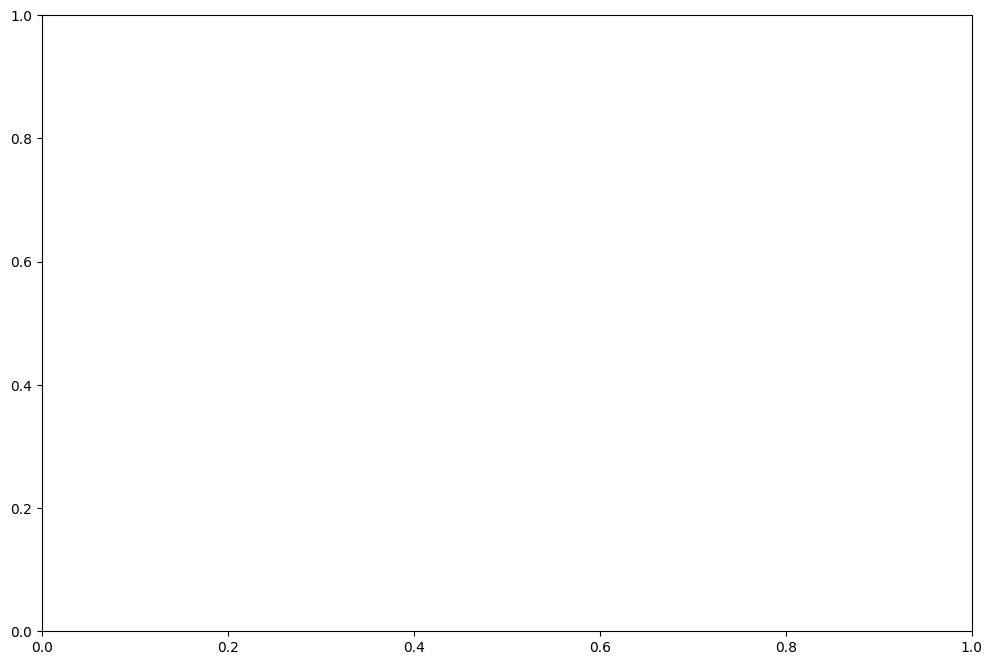

In [31]:
# Criar os vetores de iterações correspondentes
iteracoes = list(range(1000, it_max + 1, 1000))

# Plotar o primeiro gráfico (comparando SGDm, SGD2m, SGD3m)
plt.figure(figsize=(12, 8))
plt.plot(iteracoes, valores_sgd3, label='SGD3m (Mini-Batch Subgradiente)', marker='x')
plt.plot(iteracoes, valores_sgd2, label='SGD2m (Subgradiente Estocástico)', marker='o')
plt.plot(iteracoes, valores_sgd, label='SGDm (Subgradiente Básico)', marker='s')

# Adicionar título e legendas
plt.title('Comparação de Erros: SGDm, SGD2m, SGD3m', fontsize=16)
plt.xlabel('Número de iterações', fontsize=14)
plt.ylabel('$f_{it_{max}}(w_k)$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [23]:
f3m = sgd3(fm, gBm, w0, 1e-1, l2, m, B, it_max)

NameError: name 'fm' is not defined

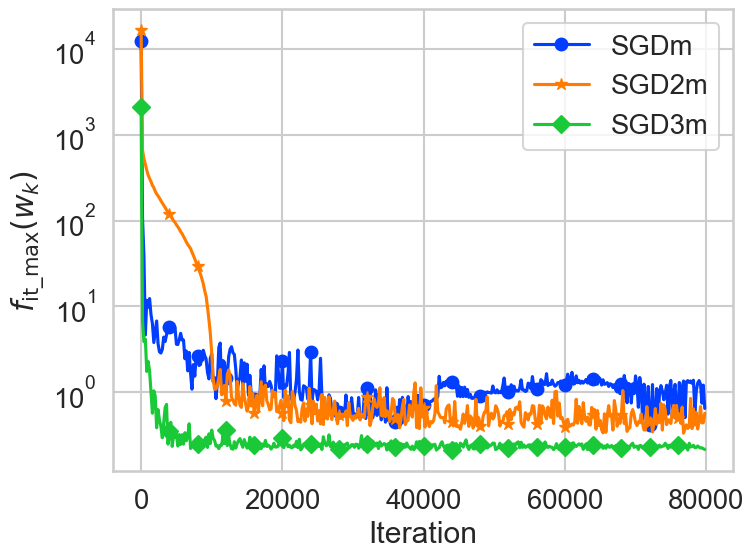

In [19]:
#Escreva o código aqui

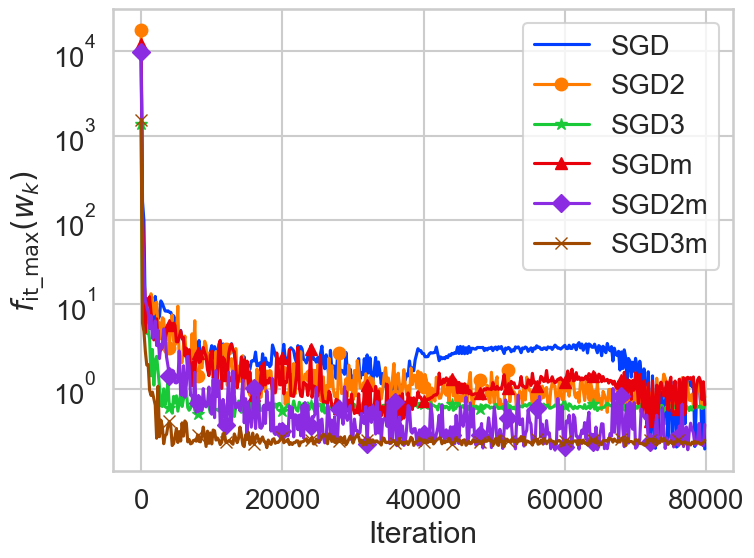

In [203]:
#Escreva o código aqui